In [1]:
import numpy as np
import pandas as pd
import math
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import src.rng_sequences, src.human_sequences,src.constants,src.uORF_Statistics
from collections import Counter
from scipy.optimize import curve_fit
import scipy.special
from scipy.stats import poisson

import polygraph.input, polygraph.sequence, polygraph.visualize

 # Generating data files

In [2]:
'''Defining params'''
seqnum=90000
seqlen=160
myu=5.345801185151601
sigma=0.8416777786431029
factor_a=66009.38523606668
params=[myu,sigma,factor_a]
np.random.seed(12345)

In [ ]:
seqs1 = src.rng_sequences.randomseqs(seqnum,seqlen,group_name="Random_gc70",seed=12345,gc_content=0.7)
seqs2 = src.rng_sequences.randomseqs(seqnum,seqlen,group_name="Random_gc50",seed=12345)

In [ ]:
seqs3=src.rng_sequences.randomlengthseqs(params,8000,90000,"Random_dl_gc50",seed=12345)
seqs4=src.rng_sequences.randomlengthseqs(params,8000,90000,"Random_dl_gc70",seed=12345,gc_content=0.7)

In [ ]:
'''This code is used to generate a dataset with continous IDs and save it in a txt file'''
randomseqs=np.concatenate([seqs1,seqs2,seqs3],axis=0)
randomseqsindex=np.array([f"seq_{i+1}" for i in range(len(randomseqs))])
randomseqs=np.vstack((randomseqsindex,randomseqs.T)).T
np.savetxt("data/random_dataset.txt",randomseqs,delimiter="\t",newline="\n",fmt='%s')

In [ ]:
'''Here we read out the human genome sequences and save it in a txt file'''
humanseqs=src.human_sequences.readFASTA("data/gencode_5utrs_human.fa")
humanseqs=src.human_sequences.delDupes(humanseqs)
np.savetxt("data/humanseqsRNA.txt",humanseqs,delimiter="\t",newline="\n",fmt='%s')

In [ ]:
''' Here we write every Sequence into one txt file'''
seqfiles=['data/humanseqsRNA.txt','data/random_dataset.txt']
with open('data/full_dataset.txt','w') as outfile:
    for fname in seqfiles:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [3]:
seqs=polygraph.input.read_seqs('data/full_dataset.txt',incl_ids=True)
seqs

,Sequence,Group
SeqID,,
ENST00000641515.2,CCCAGAUCUCUUCAGUUUUUAUGCCUCAUUCUGUGAAAAUUGCUGU...,Human
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human
ENST00000437963.5,CAGCGCUUGGGGCUCGCGGGCCGCUCCCUCCGCUCGGAAGGGAAAA...,Human
ENST00000342066.8,GCAGAGCCCAGCAGAUCCCUGCGGCGUUCGCGAGGGUGGGACGGGA...,Human
ENST00000338591.8,GGGAGUGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCUCC...,Human
...,...,...
seq_269996,UACCUUUUACUCUAGGACACGGUGAUUUCACUGAGAGCCUCACAGC...,Random_dl_gc50
seq_269997,UAUAGUGCCUUCUGUAAGCUGUCGCAGGAACUAGCAGAGGUCGCUA...,Random_dl_gc50
seq_269998,GCAAGGUAGACGCUACGUCUUCCGAUCAUAGGCUUUCCGGAGGCUG...,Random_dl_gc50


# Generating statistics for the Sequences 

In [4]:
'''Sequence lengths'''
seqs['Sequence Length']=seqs.Sequence.apply(len)

In [5]:
'''GC Content'''
seqs['GC Content']=polygraph.sequence.gc(seqs)

In [6]:
'''uORF counts'''
counts=src.uORF_Statistics.uORFs(seqs)
seqs=pd.concat([seqs,counts],axis=1)

In [7]:
seqs

,Sequence,Group,Sequence Length,GC Content,uORF_countssum,uORF_meanlength,ouORF_countssum,uORF_counts1,uORF_counts2,uORF_counts3,uORF_meanlength1,uORF_meanlength2,uORF_meanlength3,ouORF_counts1,ouORF_counts2,ouORF_counts3
SeqID,,,,,,,,,,,,,,,,
ENST00000641515.2,CCCAGAUCUCUUCAGUUUUUAUGCCUCAUUCUGUGAAAAUUGCUGU...,Human,60,0.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENST00000616016.5,GGCGGCGGAGUCUCCCAAGUCCCCGCCGGGCGGGCGCGCGCCAGUG...,Human,509,0.809430,1.0,360.0,0.0,0.0,1.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0
ENST00000437963.5,CAGCGCUUGGGGCUCGCGGGCCGCUCCCUCCGCUCGGAAGGGAAAA...,Human,60,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000342066.8,GCAGAGCCCAGCAGAUCCCUGCGGCGUUCGCGAGGGUGGGACGGGA...,Human,90,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000338591.8,GGGAGUGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCUCC...,Human,110,0.745455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_269996,UACCUUUUACUCUAGGACACGGUGAUUUCACUGAGAGCCUCACAGC...,Random_dl_gc50,551,0.504537,10.0,18.0,0.0,2.0,4.0,4.0,0.0,0.0,18.0,0.0,0.0,0.0
seq_269997,UAUAGUGCCUUCUGUAAGCUGUCGCAGGAACUAGCAGAGGUCGCUA...,Random_dl_gc50,82,0.402439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seq_269998,GCAAGGUAGACGCUACGUCUUCCGAUCAUAGGCUUUCCGGAGGCUG...,Random_dl_gc50,126,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plots

In [8]:
'''Wir kreieren Nebendataframes um das Darstellen der Daten zu erleichtern'''
gc50seqs=seqs.loc[seqs['Group']=='Random_gc50']
gc70seqs=seqs.loc[seqs['Group']=='Random_gc70']
humanseqs=seqs.loc[seqs['Group']=='Human']
gc50dlseqs=seqs.loc[seqs['Group']=='Random_dl_gc50']
lengthdistributed=pd.concat([humanseqs,gc50dlseqs])

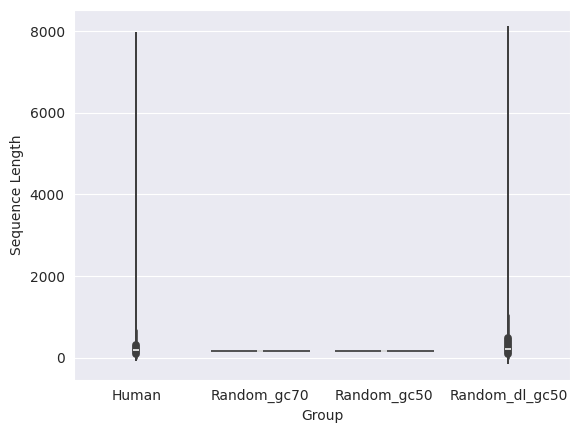

In [9]:
#Sequenzlaenge
sns.violinplot(data=seqs,x='Group',y='Sequence Length');

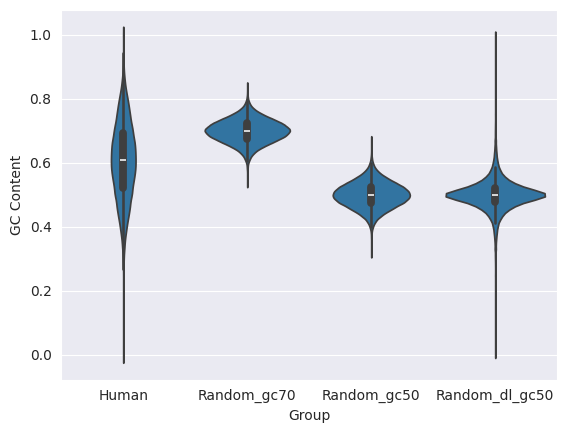

In [10]:
#GC Content 
sns.violinplot(data=seqs,x='Group',y='GC Content');

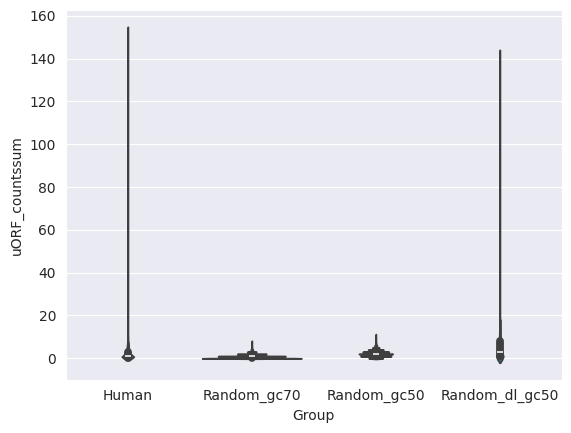

In [11]:
# uORF Anzahl(Summe aus allen reading frames)
sns.violinplot(data=seqs,x='Group',y='uORF_countssum');

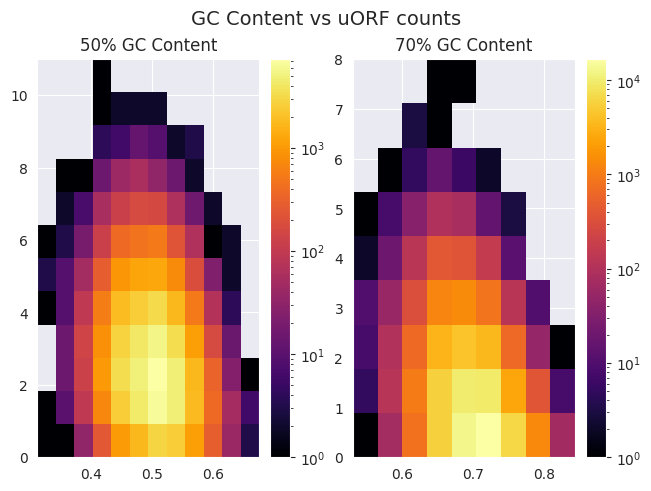

In [13]:
#GC Content vs. uORF anzahl
fig,axs = plt.subplots(nrows=1, ncols=2,layout='constrained' )
im1=axs[0].hist2d(gc50seqs['GC Content'],gc50seqs['uORF_countssum'],norm=colors.LogNorm(),cmap='inferno',bins=12)
im2= axs[1].hist2d(gc70seqs['GC Content'],gc70seqs['uORF_countssum'],norm=colors.LogNorm(),cmap='inferno',bins=9)
axs[0].set_title("50% GC Content")
axs[1].set_title("70% GC Content")
fig.colorbar(im1[3],ax=axs[0])
fig.colorbar(im2[3],ax=axs[1])
fig.suptitle('GC Content vs uORF counts',fontsize=14)
plt.show()

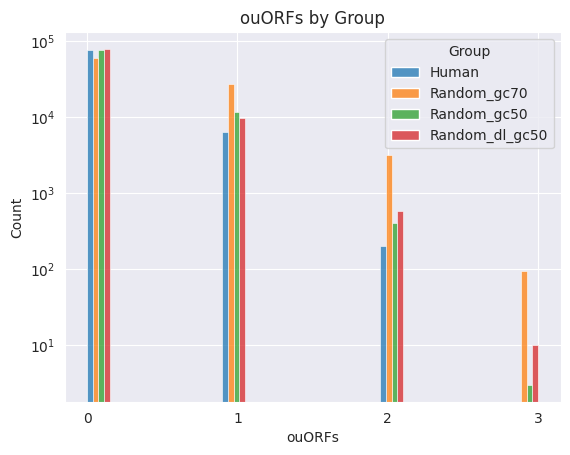

In [14]:
#Menge an overlapping uORFs pro Gruppe
im1=sns.histplot(x=seqs["ouORF_countssum"],hue=seqs["Group"],multiple="dodge")
im1.set_yscale('log')
im1.set_xticks([0,1,2,3])
im1.set_xlabel("ouORFs")
plt.title('ouORFs by Group')
plt.show()

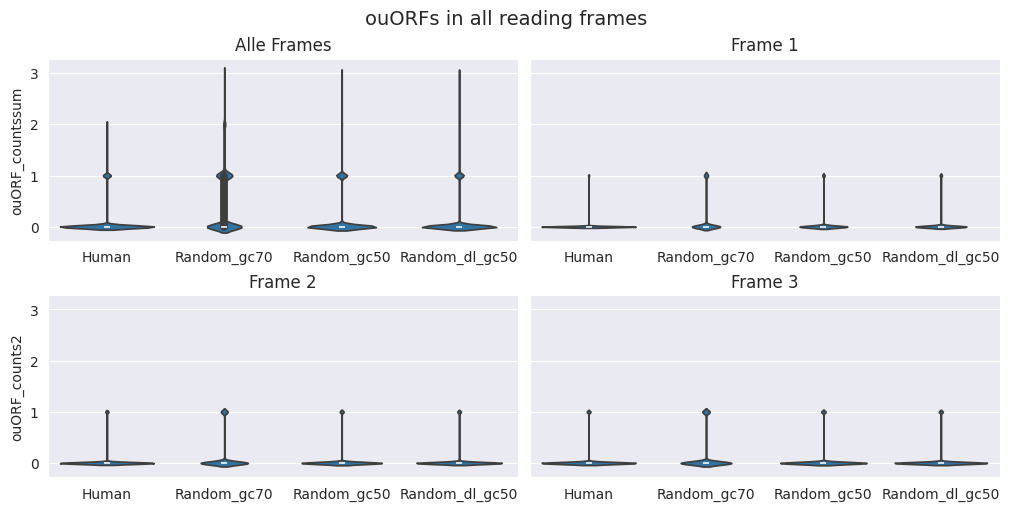

In [15]:
#overlapping uORFs in allen reading Frames
fig2, axs2=plt.subplots(2,2,layout='constrained', sharey=True,figsize=(10,5) )
sns.violinplot(x=seqs["Group"],y=seqs["ouORF_countssum"],ax=axs2[0,0])
sns.violinplot(x=seqs["Group"],y=seqs["ouORF_counts1"],ax=axs2[0,1])
sns.violinplot(x=seqs["Group"],y=seqs["ouORF_counts2"],ax=axs2[1,0])
sns.violinplot(x=seqs["Group"],y=seqs["ouORF_counts3"],ax=axs2[1,1])
for arr in axs2:
    for ax in arr:
        ax.minorticks_on()
        ax.set_xlabel("")
axs2[0,0].set_title("Alle Frames")
axs2[0,1].set_title("Frame 1")
axs2[1,0].set_title("Frame 2")
axs2[1,1].set_title("Frame 3")
fig2.suptitle('ouORFs in all reading frames',fontsize=14)
plt.show()

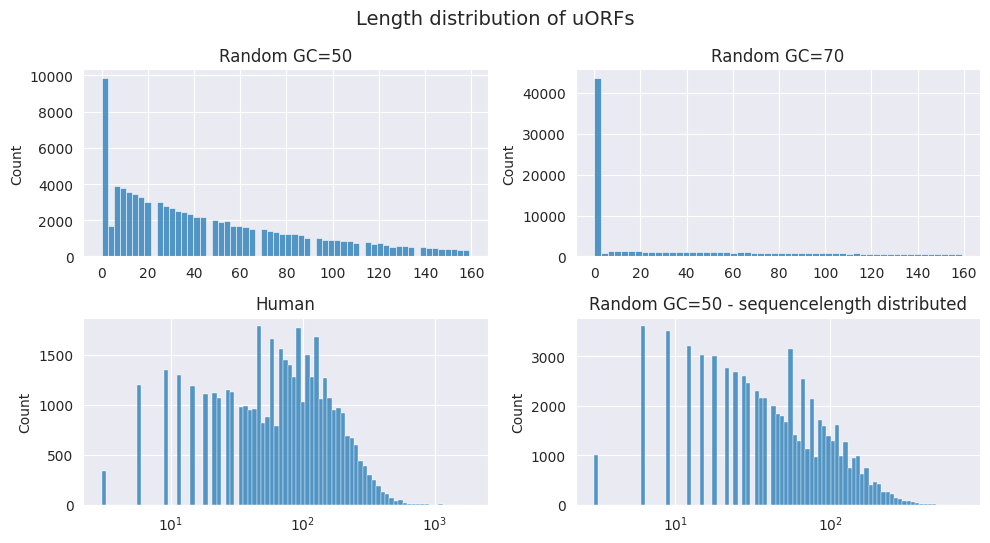

In [16]:
fig3, axs3 =plt.subplots(2,2,layout='tight',figsize=(10,5.5))
sns.histplot(x=gc50seqs['uORF_meanlength'],ax=axs3[0,0])
sns.histplot(x=gc70seqs['uORF_meanlength'],ax=axs3[0,1])
sns.histplot(x=humanseqs['uORF_meanlength'],ax=axs3[1,0],log_scale=True)
sns.histplot(x=gc50dlseqs['uORF_meanlength'],ax=axs3[1,1],log_scale=True)
for arr in axs3:
    for ax in arr:
        ax.minorticks_on()
        ax.set_xlabel("")
        #ax.set_yscale('log')
axs3[0,0].set_title("Random GC=50")
axs3[0,1].set_title("Random GC=70")
axs3[1,0].set_title("Human")
axs3[1,1].set_title("Random GC=50 - sequencelength distributed")
fig3.suptitle("Length distribution of uORFs",fontsize=14)
plt.show()

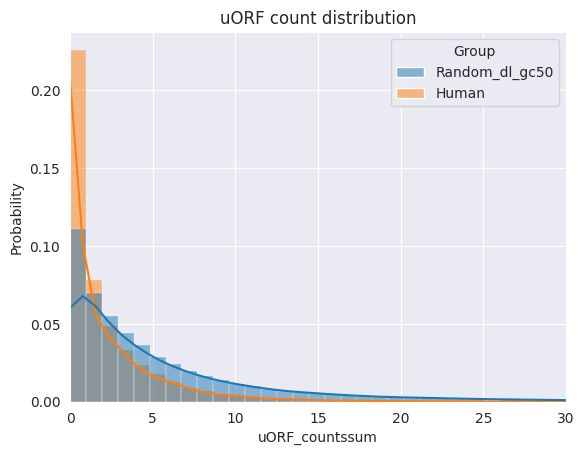

In [17]:
hue_order=['Random_dl_gc50','Human']
sns.histplot(data=lengthdistributed, x='uORF_countssum', hue='Group',stat='probability',hue_order=hue_order,kde=True,bins=160);
plt.xlim(0,30);
plt.title("uORF count distribution")
plt.show()



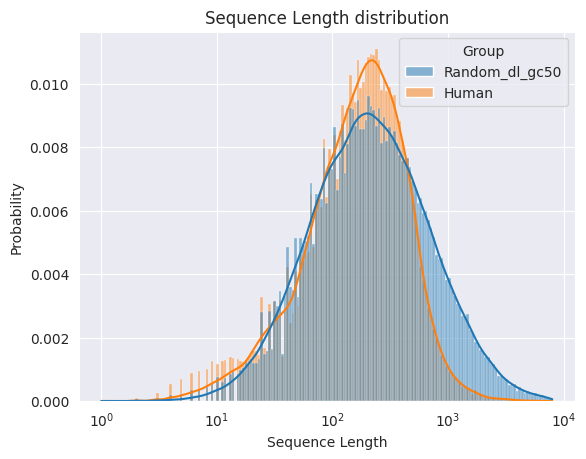

In [18]:
hue_order=['Random_dl_gc50','Human']
sns.histplot(data=lengthdistributed, x='Sequence Length', hue='Group',stat='probability',hue_order=hue_order,kde=True,log_scale=True)
plt.title("Sequence Length distribution")
plt.show()

# Metadata

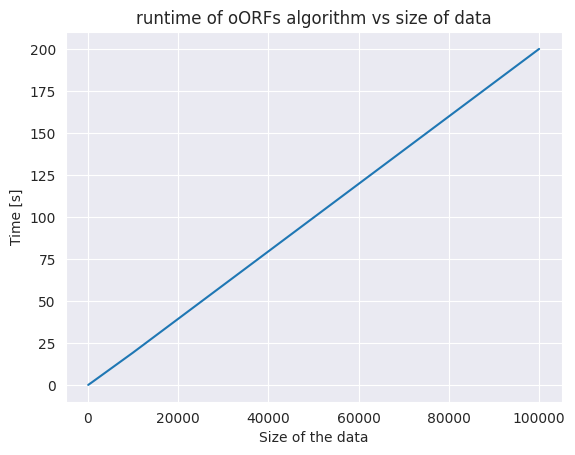

In [19]:
'''Plot of runtimes of the uORF_statistics method over the size of the data (number or length of sequences)'''
times=[0.212,1.920,19.402,200.295]
sizes=[100,1000,10000,100000]
plt.plot(sizes,times)
plt.xlabel("Size of the data")
plt.ylabel("Time [s]")
plt.title("runtime of oORFs algorithm vs size of data")
plt.show()

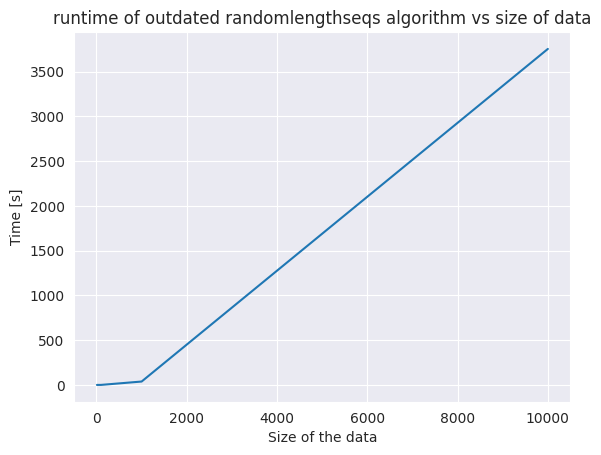

In [20]:
times=[0.021,0.256,37.857,3753]
sizes=[10,100,1000,10000]
plt.plot(sizes,times)
plt.xlabel("Size of the data")
plt.ylabel("Time [s]")
plt.title("runtime of outdated randomlengthseqs algorithm vs size of data")
plt.show()

# testing

In [ ]:
def testfunc(a,b):
    print(a+b)
def testingtestfunc(func,a,b):
    func(a,b)
    
testingtestfunc(testfunc,1,2)

In [ ]:
print(sum)

In [ ]:
rng = np.random.default_rng(seed=3)
a=rng.choice([0,1,3],3)
b=np.array([0,1,2,3])
for i in b[1:]:
    print(i)

In [ ]:
def lognormalfunc(x,myu,sigma,a):
    return a*np.exp(-1*(np.log(x)-myu)**2/(2*sigma)**2)/(x*sigma*np.sqrt(2*np.pi))

In [ ]:
sns.scatterplot(x=x_plot,y=lognormalfunc(x_plot,myu,sigma,factor_a),size=1,marker=".");

In [ ]:
x_plot=np.arange(1,8000)
distribution=lognormalfunc(x_plot,myu,sigma,factor_a)
distribution=distribution/sum(distribution)
#print(sum(distribution))
rng=np.random.default_rng()
lengths=rng.choice(x_plot, 100000 , p=distribution)

In [ ]:
im3=sns.histplot(lengths,kde=True)
im3.lines[0].set_color('crimson')


In [ ]:
im4=sns.scatterplot(x=x_plot,y=distribution,size=1,marker=".")
#im4.lines[0].set_color('crimson')

In [ ]:
lengthdata=list(humanseqs['Sequence Length'])
lengthdata=Counter(lengthdata)
x,y=[],[]
for i,j in lengthdata.items():
    x.append(i)
    y.append(j)
y=np.array(y)
sns.scatterplot(x=x,y=y,size=1,marker=".");

In [ ]:
params, cov_matrix= curve_fit(lognormalfunc,x,y)
x_plot=np.arange(1,8000)
plt.plot(x_plot,lognormalfunc(x_plot,params[0],params[1],params[2]))
plt.plot(x,y,linestyle='None',marker=".")

myu=params[0]
sigma=params[1]
factor_a=params[2]
print(myu,sigma,factor_a)


In [ ]:
def poissonfunc(x,lamb,a):
    return a*poisson.pmf(x,lamb)
params1, cov_matrix1 = curve_fit(poissonfunc,x,y)
x_plot1=(np.arange(0,8000))
plt.plot(x_plot1,poissonfunc(x_plot1,params1[0],params1[1]))
plt.plot(x,y,linestyle='None',marker=".")

In [ ]:
x_plot=np.arange(1,8000)
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

    
#plt.plot(x_plot,lognormalfunc(x_plot,myu,sigma))
#plt.plot(x_plot,softmax(lognormalfunc(x_plot,myu,sigma)))
#plt.plot(x_plot,scipy.special.softmax(lognormalfunc(x_plot,myu,sigma)))
print([sum(lognormalfunc(x_plot,myu,sigma)),sum(softmax(lognormalfunc(x_plot,myu,sigma)))])